In [23]:
import os
import numpy as np
import pandas as pd
from tabulate import tabulate
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt

script_dir = os.getcwd()
file_name = "Owid.csv"
file_path = os.path.join(script_dir, "dataset", file_name)  

df = pd.read_csv(file_path)

available_variables = df.columns.tolist()
available_years = df['Date'].unique()
available_countries = df['Country'].unique()

print("Available Variables:")
print(available_variables)
print("\nAvailable Years:")
print(available_years)
print("\nAvailable Countries:")
print(available_countries)

Available Variables:
['Country', 'Date', 'biofuel_electricity', 'coal_electricity', 'electricity_generation', 'fossil_electricity', 'gas_electricity', 'hydro_electricity', 'low_carbon_electricity', 'nuclear_electricity', 'oil_electricity', 'other_renewable_electricity', 'renewables_electricity', 'solar_electricity', 'wind_electricity', 'nuclear_share_elec']

Available Years:
[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 1900 1901 1902 1903 1904
 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918
 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932
 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946
 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960
 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 199

In [24]:
# User-defined settings
country_to_evaluate = 'World'  
variable_to_evaluate = 'electricity_generation'  
start_year_historical = 1985  
end_year_historical = 2022  
forecast_year = 2100  
seasonality_enabled = False  
seasonal_period = 20  

# Ranges for SARIMAX parameters
p_range = range(0, 2)  
d_range = range(0, 2)  
q_range = range(0, 2)  

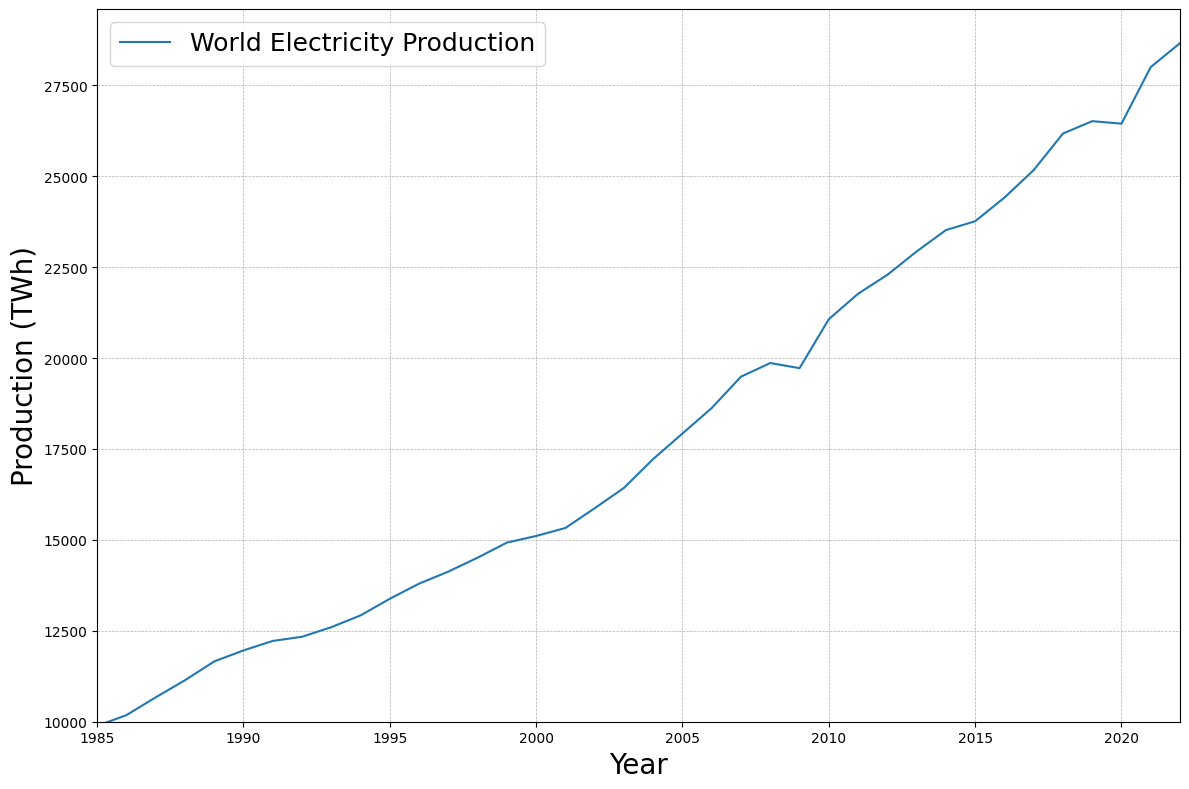

In [40]:
# Filter data for the selected country, variable, and year range
data_selected = df[(df['Country'] == country_to_evaluate) & (df['Date'] >= start_year_historical) & (df['Date'] <= end_year_historical)][['Date', variable_to_evaluate]]
data_selected.dropna(subset=[variable_to_evaluate], inplace=True)

# Plot the selected variable for the chosen country
plt.figure(figsize=(12, 8))
plt.plot(data_selected['Date'], data_selected[variable_to_evaluate], linestyle='-', label='World Electricity Production')
plt.legend(loc='upper left', fontsize=18)
plt.xlabel('Year', fontsize=20)
plt.xlim(left=start_year_historical, right=2022)
plt.ylim(10000)
plt.ylabel('Production (TWh)', fontsize=20)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [26]:
def adf_test(series, name):
    """
    Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity in a given time series.

    Parameters:
    series (pandas.Series): The time series data to be tested.
    name (str): The name of the time series for identification purposes.

    Returns:
    dict: A dictionary containing the ADF test results. The dictionary includes the following keys:
        - 'ADF Statistic': The test statistic value.
        - 'p-value': The p-value associated with the test statistic.
        - 'Number of Lags Used': The number of lags used in the regression.
        - 'Number of Observations Used': The number of observations used in the regression.
        - 'Critical Values': The critical values for different confidence levels.
        - 'Test Name': The name of the test.
    """
    adf_result = adfuller(series.dropna())
    return {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Number of Lags Used': adf_result[2],
        'Number of Observations Used': adf_result[3],
        'Critical Values': adf_result[4],
        'Test Name': name
    }

variable_series = data_selected.set_index('Date')[variable_to_evaluate].dropna()
adf_results = [
    adf_test(variable_series, 'Original (1)'),
    adf_test(np.log(variable_series), 'Log Transformed (2)'),
    adf_test(np.log(variable_series).diff().dropna(), 'Log Transformed Diff (2)'),
    adf_test(variable_series.diff().dropna(), 'Diff (3)')
]

headers = ['Test Name', 'ADF Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used', 'Critical Values']
table = [[result['Test Name'], 
          result['ADF Statistic'], 
          result['p-value'], 
          result['Number of Lags Used'], 
          result['Number of Observations Used'], 
          result['Critical Values']] for result in adf_results]
print(tabulate(table, headers=headers, tablefmt='pretty'))

+--------------------------+---------------------+-----------------------+---------------------+-----------------------------+------------------------------------------------------------------------------------+
|        Test Name         |    ADF Statistic    |        p-value        | Number of Lags Used | Number of Observations Used |                                  Critical Values                                   |
+--------------------------+---------------------+-----------------------+---------------------+-----------------------------+------------------------------------------------------------------------------------+
|       Original (1)       | 2.9706579985940307  |          1.0          |          2          |             35              | {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756} |
|   Log Transformed (2)    | -0.7742722762703893 |  0.8265628344256422   |          0          |             37              | {'1%': -3.620917522160582

In [27]:
def optimize_sarimax(series, p_range, d_range, q_range, seasonal_period, seasonality_enabled):
    """
    This function optimizes the SARIMAX model parameters to find the best combination for forecasting.

    Parameters:
    series (pandas.Series): The time series data to be used for model optimization.
    p_range (range): The range of p values to be tested for the SARIMAX model.
    d_range (range): The range of d values to be tested for the SARIMAX model.
    q_range (range): The range of q values to be tested for the SARIMAX model.
    seasonal_period (int): The seasonal period for the SARIMAX model.
    seasonality_enabled (bool): A flag indicating whether to include seasonality in the model.

    Returns:
    tuple: A tuple containing the best AIC value, the best order (p, d, q), the best seasonal order (P, D, Q, m), and the best SARIMAX model.
    """
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_mdl = None
    P = D = Q = range(2)
    m = seasonal_period
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                if seasonality_enabled:
                    for P_ in P:
                        for D_ in D:
                            for Q_ in Q:
                                try:
                                    temp_model = SARIMAX(series, order=(p, d, q),
                                                         seasonal_order=(P_, D_, Q_, m),
                                                         enforce_stationarity=False,
                                                         enforce_invertibility=False)
                                    results = temp_model.fit(disp=False)
                                    if results.aic < best_aic:
                                        best_aic = results.aic
                                        best_order = (p, d, q)
                                        best_seasonal_order = (P_, D_, Q_, m)
                                        best_mdl = results
                                except:
                                    continue
                else:
                    try:
                        temp_model = SARIMAX(series, order=(p, d, q),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
                        results = temp_model.fit(disp=False)
                        if results.aic < best_aic:
                            best_aic = results.aic
                            best_order = (p, d, q)
                            best_seasonal_order = None
                            best_mdl = results
                    except:
                        continue
    return best_aic, best_order, best_seasonal_order, best_mdl

best_aic, best_order, best_seasonal_order, best_model = optimize_sarimax(variable_series.dropna(), p_range, d_range, q_range, seasonal_period, seasonality_enabled)
best_aic_log, best_order_log, best_seasonal_order_log, best_model_log = optimize_sarimax(np.log(variable_series).diff().dropna(), p_range, d_range, q_range, seasonal_period, seasonality_enabled)
best_aic_diff, best_order_diff, best_seasonal_order_diff, best_model_diff = optimize_sarimax(variable_series.diff().dropna(), p_range, d_range, q_range, seasonal_period, seasonality_enabled)

results = [
    ["Original (1)", best_order, best_aic, best_model.bic],
    ["Log-Differenced (2)", best_order_log, best_aic_log, best_model_log.bic],
    ["Differenced (3)", best_order_diff, best_aic_diff, best_model_diff.bic]
]

table = tabulate(results, headers=["Model", "Order (p, d, q)", "AIC", "BIC"], tablefmt="pretty")
print(table)



c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\s

+---------------------+-----------------+--------------------+---------------------+
|        Model        | Order (p, d, q) |        AIC         |         BIC         |
+---------------------+-----------------+--------------------+---------------------+
|    Original (1)     |    (1, 1, 1)    | 511.85655082257625 |  516.5225950070445  |
| Log-Differenced (2) |    (1, 0, 1)    | -184.5822807287192 | -179.91623654425098 |
|   Differenced (3)   |    (0, 1, 1)    | 498.47341701527796 |  501.5261380645103  |
+---------------------+-----------------+--------------------+---------------------+


c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\s

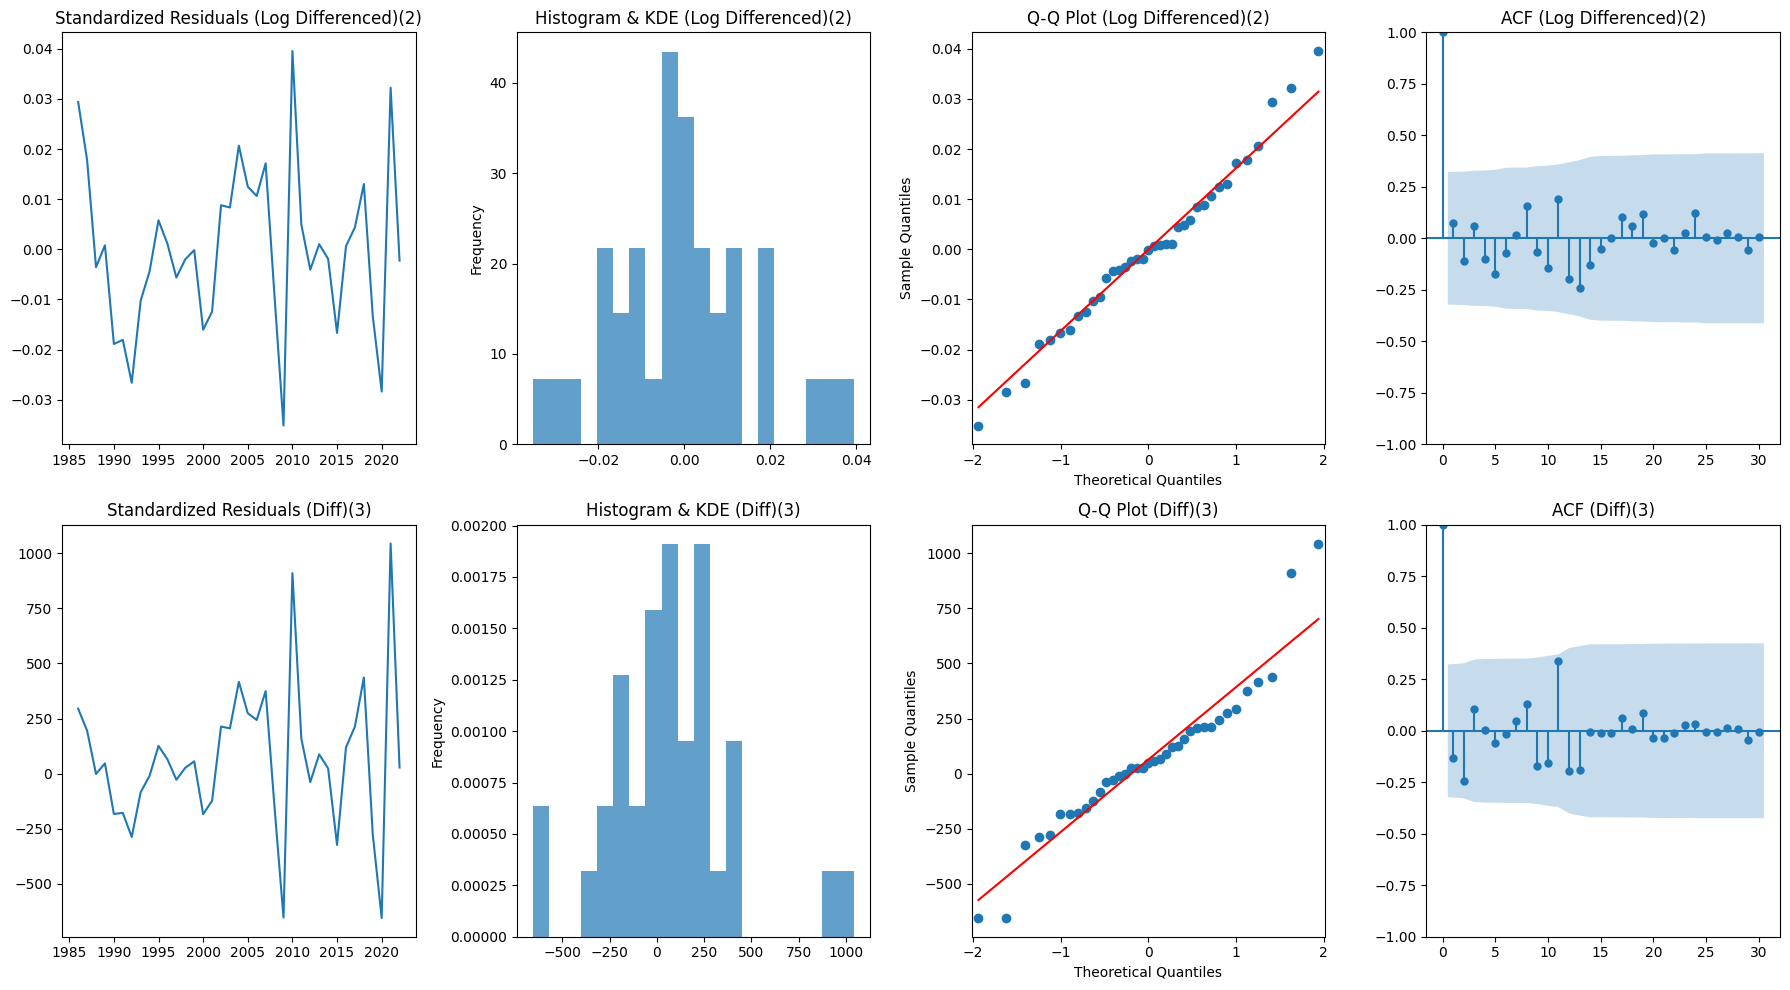

In [28]:
# Assume residuals_normal, residuals_log, and residuals_diff are already defined
residuals_normal = best_model.resid
residuals_log = best_model_log.resid
residuals_diff = best_model_diff.resid

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# # Standardized Residuals (Normal)
# axes[0, 0].plot(residuals_normal)
# axes[0, 0].set_title('Standardized Residuals (Normal)(1)')

# residuals_normal.plot(kind='hist', density=True, ax=axes[0, 1], alpha=0.7, bins=20)
# axes[0, 1].set_title('Histogram & KDE (Normal)(1)')

# sm.qqplot(residuals_normal, line='s', ax=axes[0, 2])
# axes[0, 2].set_title('Q-Q Plot (Normal)(1)')

# sm.graphics.tsa.plot_acf(residuals_normal, lags=30, ax=axes[0, 3])
# axes[0, 3].set_title('ACF (Normal)(1)')

# Standardized Residuals (Log)
axes[0, 0].plot(residuals_log)
axes[0, 0].set_title('Standardized Residuals (Log Differenced)(2)')

residuals_log.plot(kind='hist', density=True, ax=axes[0, 1], alpha=0.7, bins=20)
axes[0, 1].set_title('Histogram & KDE (Log Differenced)(2)')

sm.qqplot(residuals_log, line='s', ax=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot (Log Differenced)(2)')

sm.graphics.tsa.plot_acf(residuals_log, lags=30, ax=axes[0, 3])
axes[0, 3].set_title('ACF (Log Differenced)(2)')

# Standardized Residuals (Diff)
axes[1, 0].plot(residuals_diff)
axes[1, 0].set_title('Standardized Residuals (Diff)(3)')

residuals_diff.plot(kind='hist', density=True, ax=axes[1, 1], alpha=0.7, bins=20)
axes[1, 1].set_title('Histogram & KDE (Diff)(3)')

sm.qqplot(residuals_diff, line='s', ax=axes[1, 2])
axes[1, 2].set_title('Q-Q Plot (Diff)(3)')

sm.graphics.tsa.plot_acf(residuals_diff, lags=30, ax=axes[1, 3])
axes[1, 3].set_title('ACF (Diff)(3)')

plt.tight_layout()
plt.show()

In [29]:
# Forecasting to the specified end year
last_data_year = variable_series.index[-1]
forecast_years = pd.date_range(start=pd.to_datetime(str(last_data_year + 1)), end=pd.to_datetime(f"{forecast_year+1}"), freq='A').year
steps_to_end_year = len(forecast_years)

# Forecast for normal data
forecast_normal = best_model.get_forecast(steps=steps_to_end_year)
forecast_values_normal = forecast_normal.predicted_mean
forecast_ci_normal = forecast_normal.conf_int(alpha=0.05)
forecast_ci_normal.columns = ['mean_ci_lower_normal', 'mean_ci_upper_normal']
forecast_values_normal.index = forecast_years
forecast_ci_normal.index = forecast_years

# Forecast for log differenced data
forecast_log_diff = best_model_log.get_forecast(steps=steps_to_end_year)
forecast_values_log_diff = forecast_log_diff.predicted_mean
forecast_ci_log_diff = forecast_log_diff.conf_int(alpha=0.05)
forecast_ci_log_diff.columns = ['mean_ci_lower_log_diff', 'mean_ci_upper_log_diff']
forecast_values_log_diff.index = forecast_years
forecast_ci_log_diff.index = forecast_years

# Transform the log differenced forecast back to original scale
forecast_values_log = np.exp(np.cumsum(forecast_values_log_diff) + np.log(variable_series.iloc[-1]))
forecast_ci_lower_log = np.exp(np.cumsum(forecast_ci_log_diff['mean_ci_lower_log_diff']) + np.log(variable_series.iloc[-1]))
forecast_ci_upper_log = np.exp(np.cumsum(forecast_ci_log_diff['mean_ci_upper_log_diff']) + np.log(variable_series.iloc[-1]))

# Forecast for differenced data
forecast_diff = best_model_diff.get_forecast(steps=steps_to_end_year)
forecast_values_diff = forecast_diff.predicted_mean
forecast_ci_diff = forecast_diff.conf_int(alpha=0.05)
forecast_ci_diff.columns = ['mean_ci_lower_diff', 'mean_ci_upper_diff']
forecast_values_diff.index = forecast_years
forecast_ci_diff.index = forecast_years

# Transform the differenced forecast back to original scale
forecast_values_cumulative_diff = variable_series.iloc[-1] + forecast_values_diff.cumsum()
ci_lower_cumulative_diff = variable_series.iloc[-1] + forecast_ci_diff['mean_ci_lower_diff'].cumsum()
ci_upper_cumulative_diff = variable_series.iloc[-1] + forecast_ci_diff['mean_ci_upper_diff'].cumsum()

C:\Users\Yerko\AppData\Local\Temp\ipykernel_29944\3637015628.py:3: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_years = pd.date_range(start=pd.to_datetime(str(last_data_year + 1)), end=pd.to_datetime(f"{forecast_year+1}"), freq='A').year
c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Yerko\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No sup

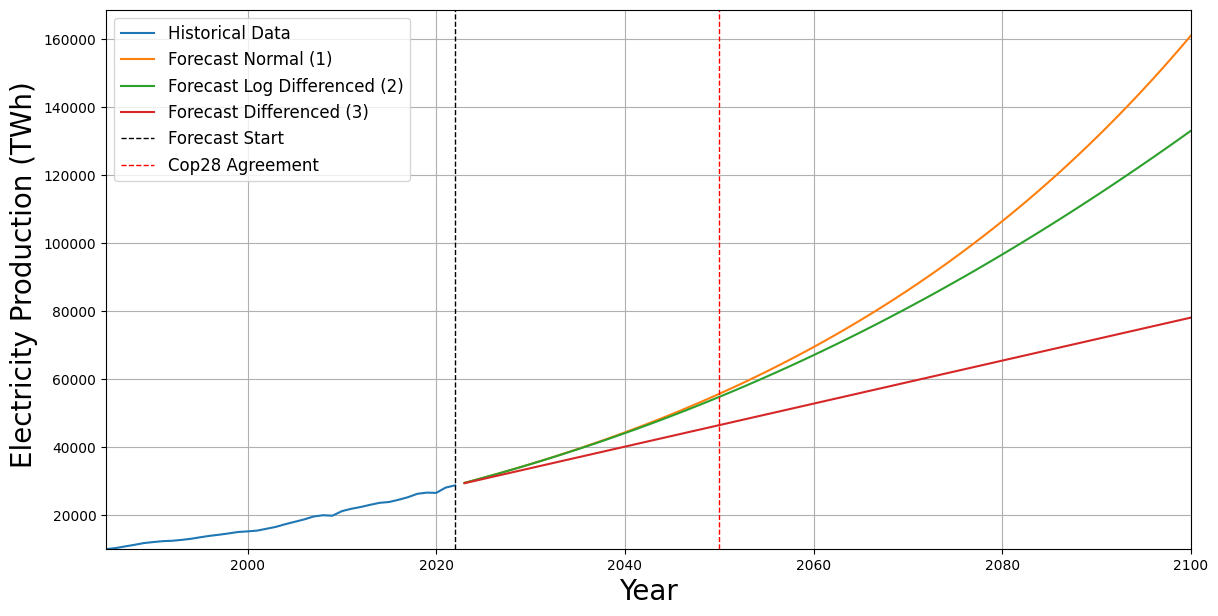

In [30]:
# Plot Forecasts
plt.figure(figsize=(14, 7))
plt.plot(variable_series.index, variable_series, label='Historical Data')
plt.plot(forecast_values_normal.index, forecast_values_normal, label='Forecast Normal (1)')
plt.plot(forecast_values_log.index, forecast_values_log, label='Forecast Log Differenced (2)')
plt.plot(forecast_values_cumulative_diff.index, forecast_values_cumulative_diff, label='Forecast Differenced (3)')


plt.axvline(x=last_data_year, color='black', linestyle='--', linewidth=1, label='Forecast Start')
plt.axvline(x=2050, color='red', linestyle='--', linewidth=1, label='Cop28 Agreement')
plt.xlabel('Year', fontsize=20)
plt.ylabel(' Electricity Production (TWh)', fontsize=20)
plt.xlim(left=start_year_historical, right=2100)
plt.ylim(bottom=10000)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()